# 🖥️ Environment set-up

📦Import the required packages and download the GitHub repository (including some data).

In [1]:
# Universal setup for both Colab and local Jupyter
print("Setting up workshop environment...")

# Clone the repository
!git clone https://github.com/Mark-Kac-Center/MFSCA.git

# Change to repository directory
import os
import sys
os.chdir('MFSCA')

# Install required packages for FSCA
print("Installing required packages...")
!pip install -r requirements.txt

# Install required packages for the preprocessing module
# print("Installing required packages...")
# !pip install -r requirements_ext.txt

# Add current directory to Python path (works everywhere)
sys.path.append(os.getcwd())

print("Setup complete! Ready to begin.")

Setting up workshop environment...
Cloning into 'MFSCA'...
remote: Enumerating objects: 315, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 315 (delta 15), reused 15 (delta 7), pack-reused 279 (from 2)
Receiving objects: 100% (315/315), 74.58 MiB | 21.94 MiB/s, done.
Resolving deltas: 100% (134/134), done.
Installing required packages...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Succes

Setup complete! Ready to begin.


Colab will ask you to restart session. After you have done that, you can continue by running the cells below (do not rerun the cell above).

In [1]:
# Verify installation - works on all platforms
import subprocess
import sys

def check_package(package_name):
    try:
        result = subprocess.run([sys.executable, '-m', 'pip', 'show', package_name],
                              capture_output=True, text=True)
        if result.returncode == 0:
            print(f"✓ {package_name} is installed")
            return True
        else:
            print(f"✗ {package_name} is NOT installed")
            return False
    except Exception as e:
        print(f"Error checking {package_name}: {e}")
        return False

# Check all required packages
packages = ['MFDFA', 'nibabel', 'numpy', 'packaging']
print("Verifying package installations:")
for pkg in packages:
    check_package(pkg)

Verifying package installations:
✓ MFDFA is installed
✓ nibabel is installed
✓ numpy is installed
✓ packaging is installed


In [ ]:
# ⚠️ In case installing from requirements haven't worked locally, (it should've worked in Colab)
# install the packages manually.
# !pip install MFDFA==0.4.3

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import nibabel as nib # Needed for importing Nifti (f)MRI files

# Change to repository directory
import os
import sys
if os.path.exists('MFSCA'): os.chdir('MFSCA') # ⚠️ This will only work after restarting session, as mentioned above.

import fsca

# 💡 Idea
<img src="https://github.com/Mark-Kac-Center/MFSCA/blob/main/imgs/flowchart.png?raw=1" width="600" alt="Flow chart">

# 📱 Simulated fractals

Let's start with a model of Fractional Brownion Motion in two dimensions.

Examples for $H_{{image}}= 0.1 - 0.9$ are provided in 📁 `/MFSCA/FBM2D_data`.
Let's load the files.


⚠️ Hopefully, you working directory is already `/MFSCA`.


In [3]:
!ls FBM2D_data

a	       FBM2D_H02.mat  FBM2D_H04.mat  FBM2D_H06.mat  FBM2D_H08.mat
FBM2D_H01.mat  FBM2D_H03.mat  FBM2D_H05.mat  FBM2D_H07.mat  FBM2D_H09.mat


In [4]:
import scipy.io

# Load all FBM2D data into a single array
def load_all_fbm_data():
    data_list = []
    h_values = []

    for i in range(9):
        h_val = f'H0{i+1}'
        filename = f'FBM2D_data/FBM2D_{h_val}.mat'

        try:
            mat_data = scipy.io.loadmat(filename)
            data_list.append(mat_data[f'FBM2D_{h_val}'])
            h_values.append((i+1)/10)  # Store actual H values: 0.1, 0.2, ..., 0.9
            print(f"Loaded {filename}")
        except FileNotFoundError:
            print(f"File not found: {filename}")

    # Stack all arrays along a new axis (first dimension)
    # Shape will be (9, height, width) assuming all images have same dimensions
    fbm_data = np.stack(data_list, axis=0)

    return fbm_data, np.array(h_values)

# Load the data
fbm_array, h_values = load_all_fbm_data()
print(f"Combined array shape: {fbm_array.shape}")
print(f"H values: {h_values}")

Loaded FBM2D_data/FBM2D_H01.mat
Loaded FBM2D_data/FBM2D_H02.mat
Loaded FBM2D_data/FBM2D_H03.mat
Loaded FBM2D_data/FBM2D_H04.mat
Loaded FBM2D_data/FBM2D_H05.mat
Loaded FBM2D_data/FBM2D_H06.mat
Loaded FBM2D_data/FBM2D_H07.mat
Loaded FBM2D_data/FBM2D_H08.mat
Loaded FBM2D_data/FBM2D_H09.mat
Combined array shape: (9, 256, 256)
H values: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


And let's plot all of them. Notice, how the smoothness (or persistence / antipersistance) of the FBM changes with $H_{image}$.

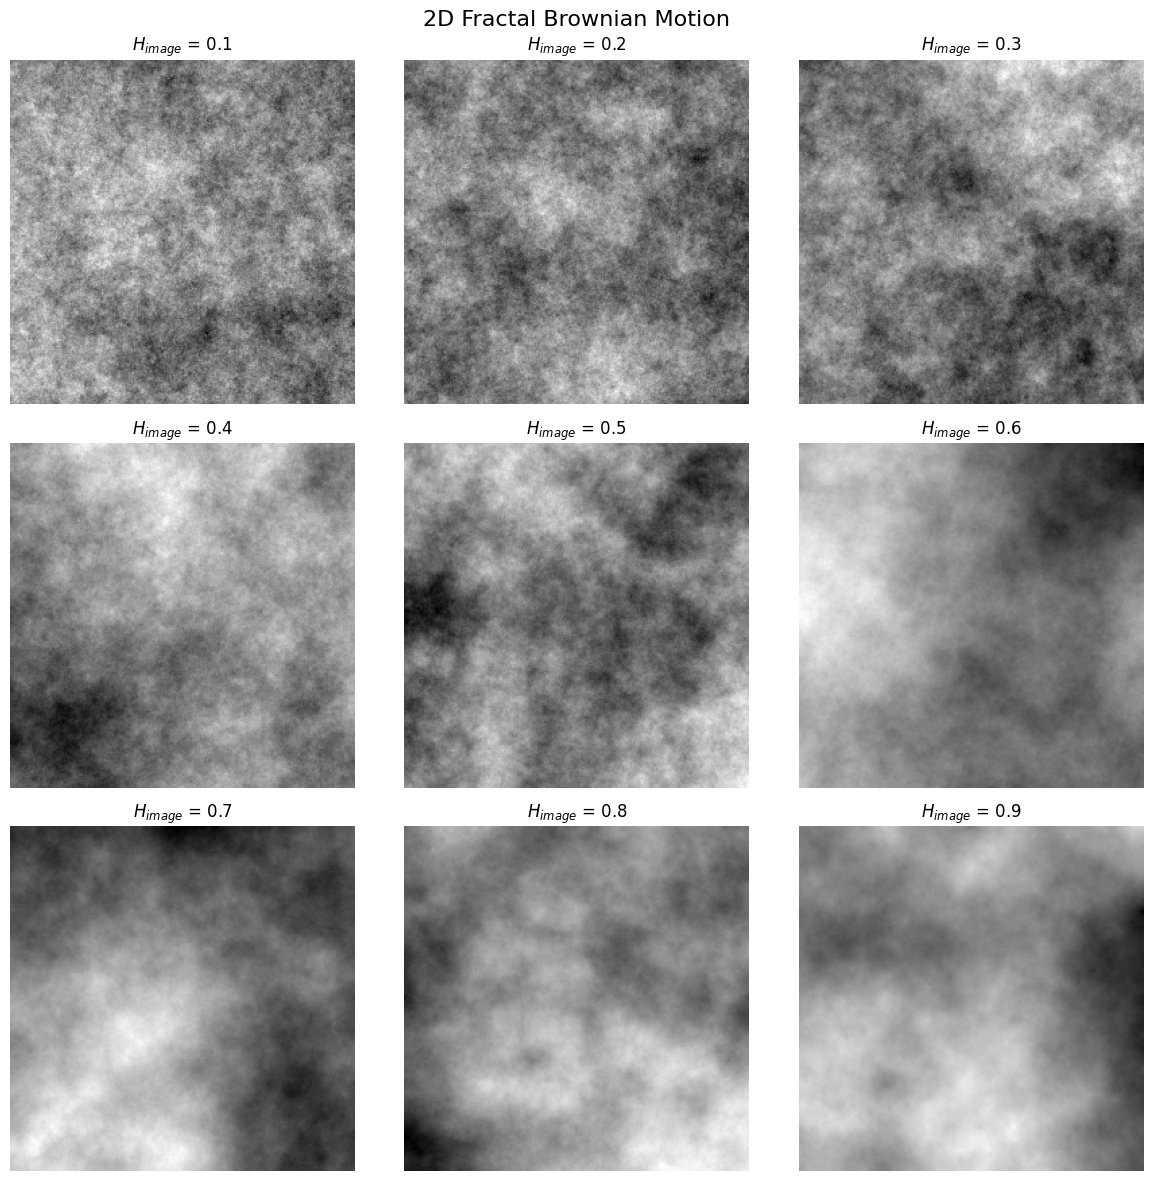

In [5]:
# Plot using the loaded array
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for i in range(len(fbm_array)):
    axes[i].imshow(fbm_array[i], cmap='gray')
    axes[i].set_title(f'$H_{{image}}$ = {h_values[i]:.1f}')
    axes[i].axis('off')

plt.suptitle('2D Fractal Brownian Motion', fontsize=16)
plt.tight_layout()
plt.show()

## 🔬 Analysing an Individual 2D image


As a reminder, MF-DFA computes the detrended variances, $F^2(\nu,s)$ for all segments $\nu$ and the respective segment lengths $s$  
and then, for all possible segment lengths, averages them over $\nu$s and the $q$-th order fluctuation function:  

$F_q(s)=\left(\frac{1}{2M_s}\sum_{\nu=1}^{2M_s}\left[F^2(\nu,s)\right]^{q/2}\right)^{1/q},\quad q\in\mathbb{R}\backslash\{0\}.$

For a signal with fractal properties it manifests a power-law-type behaviour (over a wide range of scales $s$):

$F_q(s)\sim s^{h(q)}$.

The family of exponents $h(q)$ are the so-called generalised Hurst exponents.
For a monofractal signal $h(2)\equiv H=\textrm{const.}$  
For short-range correlated time series $H\sim 0.5$.  
For long-range monofractal-correlated time series $H$ deviates from 0.5:  
- $0<H<0.5$ (antipersistent signal)
- $0.5<H<1$ (persistent signal).

Let's load the FSCA pipeline dedicated to 2D images and take a look at the key objects in the pipeline variable.

In [6]:
pipe = fsca.pipeline_2d(verbose = True)
pipe.run(fbm_array[0])

# key fractal objects:
print('\tpipe.fqs',pipe.fqs.shape)
print('\tpipe.scales',pipe.scales.shape)
print('\tpipe.qorders',pipe.qorders.shape)
print('\tpipe.ghs', pipe.ghs.shape)

load_data(): data.shape = (256, 256)
set_proc_mode(): _proc_mode = single
map_data_to_sfc2d(): sfc_type = hilbert
map_data_to_sfc2d(): sfcs.shape = (65536,)
calc_mfdfa(): scales = (10, None, 30)
calc_mfdfa(): mfdfa_lib = py
calc_mfdfa(): scales resolved = [   10    13    16    20    26    33    42    53    68    86   109   139
   177   224   285   362   460   584   742   943  1198  1521  1933  2455
  3119  3962  5033  6394  8122 10318 13107]
calc_mfdfa(): qorders resolved = [-4.  -3.8 -3.6 -3.4 -3.2 -3.  -2.8 -2.6 -2.4 -2.2 -2.  -1.8 -1.6 -1.4
 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2  1.4  1.6
  1.8  2.   2.2  2.4  2.6  2.8  3.   3.2  3.4  3.6  3.8  4. ]
calc_mfdfa(): fqs.shape = (31, 40)
calc_mfdfa(): scales.shape = (31,)
calc_mfdfa(): qorders.shape = (40,)
calc_ghurst(): scale_preset = small_scales
calc_ghurst(): min_scale_ix = None, max_scale_ix = 5
calc_ghurst(): ghs.shape = (40,)
calc_ghurst(): ghs_res.shape = (40,)
(39,) (39,)
calc_falpha(): alphas.shape = (39

The dimensions follow:

1. fluctuation function Fq stored as numpy.array with shape:
```pipe.fqs.shape = (N_SLICES, N_SCALES, N_QORDERS)```

2. scale values stored as numpy.array with shape:
```pipe.scales.shape = (N_SLICES, N_SCALES)```

3. q orders stored as numpy.array with shape:
```pipe.qorders.shape (N_QORDERS)```

3. generalized Hurst exponents H stored as numpy.array with shape:
```pipe.ghs.shape = (N_SLICES, N_QORDERS)```

where:
- ```N_SCALES``` - number of fluctuation scales $s$
- ```N_QORDERS``` - number of fluctuation orders $q$
- ```N_SLICES``` - number of scans

For 2D images like here, the ```N_SLICES``` dimension disappears.

Now, we are going to:
1. plot all the $q$-dependent fluctuation functions `pipe.fqs`  
2. highlight in <span style="color:red">red colour</span> the one for which `pipe.qorders == 2`.  
3. plot the line with the slope given by the generalised Hurst exponent `pipe.ghs`  
obtained with the same order $q=2$, as a reference.

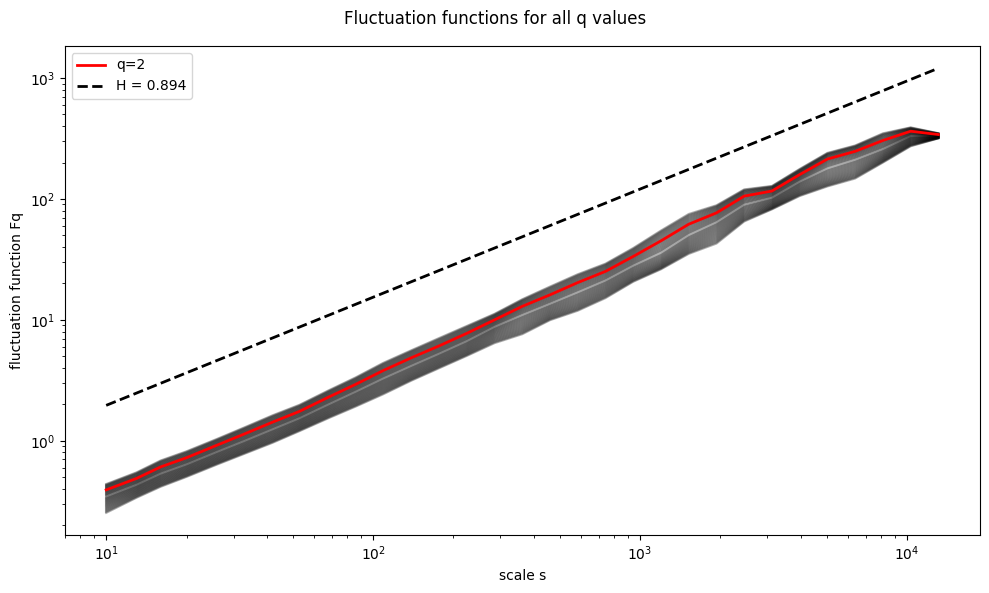

In [ ]:
q_ix_equal_two = np.argwhere(pipe.qorders == 2).item()

# Plot all fluctuation functions for different q values
fig, ax = plt.subplots(figsize=(10, 6))
s = pipe.scales

# Plot all q values
for i in range(pipe.fqs.shape[1]):
    ax.plot(s, pipe.fqs[:, i], '-', alpha=0.3, color='black')  # Adjust q labeling as needed

# Highlight the q=2 case
F2 = pipe.fqs[:, q_ix_equal_two]
ax.plot(s, F2, '-', linewidth=2, color='red', label=f'q=2')

# Add the reference line for Hurst exponent
Hurst_H = pipe.ghs[q_ix_equal_two]
h = s**Hurst_H * s[-1]**(-Hurst_H)
h = h * F2[0] / h[0] * 5 # rescale the reference line for clarity
ax.plot(s, h, '--', color='black', linewidth=2, label=f'H = {Hurst_H:.3f}')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('fluctuation function Fq')
ax.set_xlabel('scale s')
ax.legend()
fig.suptitle('Fluctuation functions for all q values')
plt.tight_layout()

For now, we are focusing on the monofractal characteristics, i.e. $H = h(2)$.  
Let us check how well the method retrieves the original $H_{image}$.

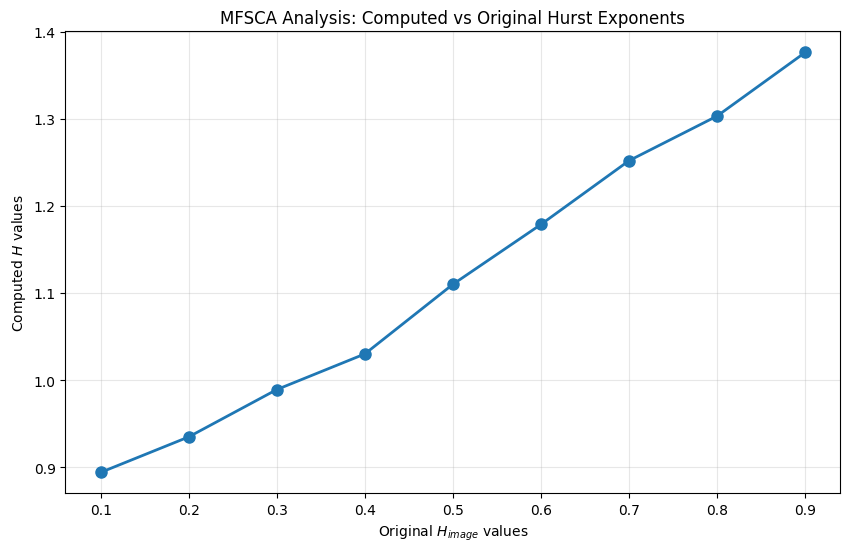

In [ ]:
# Compute H for all the loaded FBM parameters
H = []
for i in range(9):
    pipe = fsca.pipeline_2d()
    pipe.run(fbm_array[i])
    q_ix_equal_two = np.argwhere(pipe.qorders == 2).item()
    H.append(pipe.ghs[q_ix_equal_two])
H = np.array(H)

# Plot computed vs original H values
plt.figure(figsize=(10, 6))
plt.plot(h_values, H, 'o-', markersize=8, linewidth=2, label='Computed H')
plt.xlabel('Original $H_{image}$ values')
plt.ylabel('Computed $H$ values')
plt.title('MFSCA Analysis: Computed vs Original Hurst Exponents')
# plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

You can do that faster by using the 2D + 1D pipeline `pipeline_2x1d()`.

In [20]:
pipe = fsca.pipeline_2x1d(verbose = True)
pipe.run(fbm_array) # Data is resolved along the first dimension

# Now the dimensions contain N_SLICES (images with consequtive H_image parameter)
print('\tpipe.fqs',pipe.fqs.shape) # (N_SLICES, N_SCALES, N_QORDERS)
print('\tpipe.scales',pipe.scales.shape) # (N_SLICES, N_SCALES)
print('\tpipe.qorders',pipe.qorders.shape) # (N_QORDERS)
print('\tpipe.ghs', pipe.ghs.shape) # (N_SLICES, N_QORDERS)

load_data(): data.shape = (9, 256, 256)
set_proc_mode(): _proc_mode = single
map_data_to_sfc2d(): sfc_type = hilbert
map_data_to_sfc2d(): sfcs.shape = (9, 65536)
calc_mfdfa(): scales = (10, None, 30)
calc_mfdfa(): mfdfa_lib = py
calc_mfdfa(): scales resolved = [   10    13    16    20    26    33    42    53    68    86   109   139
   177   224   285   362   460   584   742   943  1198  1521  1933  2455
  3119  3962  5033  6394  8122 10318 13107]
calc_mfdfa(): qorders resolved = [-4.  -3.8 -3.6 -3.4 -3.2 -3.  -2.8 -2.6 -2.4 -2.2 -2.  -1.8 -1.6 -1.4
 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2  1.4  1.6
  1.8  2.   2.2  2.4  2.6  2.8  3.   3.2  3.4  3.6  3.8  4. ]
calc_mfdfa(): fqs.shape = (9, 31, 40)
calc_mfdfa(): scales.shape = (9, 31)
calc_mfdfa(): qorders.shape = (40,)
calc_ghurst(): scale_preset = small_scales
calc_ghurst(): min_scale_ix = None, max_scale_ix = 5
calc_ghurst(): ghs.shape = (9, 40)
calc_ghurst(): ghs_res.shape = (9, 40)
calc_falpha(): alphas.shape = (

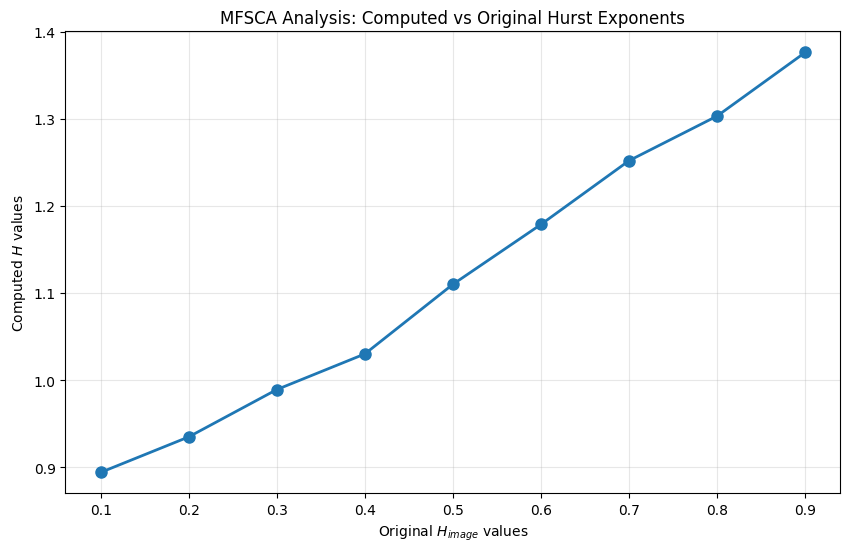

In [15]:
q_ix_equal_two = np.argwhere(pipe.qorders == 2).item()
H = pipe.ghs[:,q_ix_equal_two]

# Plot computed vs original H values
plt.figure(figsize=(10, 6))
plt.plot(h_values, H, 'o-', markersize=8, linewidth=2, label='Computed H')
plt.xlabel('Original $H_{image}$ values')
plt.ylabel('Computed $H$ values')
plt.title('MFSCA Analysis: Computed vs Original Hurst Exponents')
# plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 🧪 Your Playground

If you would like only the data vectorised into 1D along the Hilbert curve use `pipe.sfcs`.

In [21]:
pipe.sfcs

array([[-0.06889658, -0.44096428,  0.72407356, ...,  2.30646339,
         2.22119768,  0.67239295],
       [-0.59866594, -0.28051718, -1.24383327, ..., -0.85408984,
         0.60805153, -0.08116547],
       [-1.04601331, -0.96611968, -1.19413488, ...,  0.18614252,
         0.26478325, -0.14925618],
       ...,
       [-1.50276523, -1.52743146, -1.46667256, ...,  0.06610838,
         0.05736652,  0.06403282],
       [-0.09700057, -0.07674316, -0.08441511, ..., -0.61141164,
        -0.59624471, -0.59561131],
       [ 0.48018947,  0.48028527,  0.46521783, ...,  0.72303956,
         0.72708719,  0.72607183]])

In pipe.run one can pass various parameters:

* `scales` = (SMALLEST_SCALE, LARGEST_SCALE, NUM_SCALES) or np.ndarray

specifies the scales at which fluctuation function Fq is calculated. One can also pass an array of values.

* `qorders` = np.ndarray

specifies the q exponents for which fluctuation function Fq is calculated

* `scale_preset` = 'all_scales', 'small_scales', 'large_scales'

specifies which scale points to take in the calculation of generalized Hurst exponents.

* `min_scale_ix`, `max_scale_ix`

instead of giving a `scale_preset`, one can pass the start and stop index value for scales over which the generalized Hurst exponents will be fitted.

<!-- Other options:
The type of space-filling algorithm to use. Possible values are ['hilbert','hilbert3d','gilbert','data-driven']
`pipe.map_data_to_sfc2d(sfc_type='data-driven')` -->

In [24]:
pipe = fsca.pipeline_2x1d(verbose = True)
pipe.run(fbm_array,
         scales = np.array([5,10,20]),
         qorders = np.array([-2,2]))

load_data(): data.shape = (9, 256, 256)
set_proc_mode(): _proc_mode = single
map_data_to_sfc2d(): sfc_type = hilbert
map_data_to_sfc2d(): sfcs.shape = (9, 65536)
calc_mfdfa(): scales = [ 5 10 20]
calc_mfdfa(): mfdfa_lib = py
calc_mfdfa(): scales resolved = [ 5 10 20]
calc_mfdfa(): qorders resolved = [-2  2]
calc_mfdfa(): fqs.shape = (9, 3, 2)
calc_mfdfa(): scales.shape = (9, 3)
calc_mfdfa(): qorders.shape = (2,)
calc_ghurst(): scale_preset = small_scales
calc_ghurst(): min_scale_ix = None, max_scale_ix = 5
calc_ghurst(): ghs.shape = (9, 2)
calc_ghurst(): ghs_res.shape = (9, 2)
calc_falpha(): alphas.shape = (9, 1)
calc_falpha(): fs.shape = (9, 1)
calc_falpha(): Ds.shape = (9,)
calc_falpha(): As.shape = (9,)


# 🧠 Single file MRI

We are going to analyse a couple of MRI scans from the [The Open Access Series of Imaging Studies](https://sites.wustl.edu/oasisbrains), namely OASIS-1.



In [16]:
experiment_dir = Path('.') / 'Example_experiment' # ⚠️ Hopefully, you working directory still is `/MFSCA`.
data_dir = experiment_dir / 'scans'
output_dir = experiment_dir / 'output'
# state_path = output_dir / f'{slice_axis}'

data_files = list(data_dir.glob("*.nii.gz"))
meta_file = experiment_dir / 'experiment_metadata.csv'

metadata = pd.read_csv(meta_file,delimiter=';')
# Add file paths to metadata to keep alignment
metadata["file_name"] = data_files
metadata

,ID,Subject,Session,Cohort,Age,Gender,CDR,file_name
0,OAS1_0190_MR1,190,1,Middle Aged Control,43,M,0.0,Example_experiment/scans/OAS1_0363_MR1_mpr_n4_...
1,OAS1_0268_MR1,268,1,MCI,78,M,1.0,Example_experiment/scans/OAS1_0451_MR1_mpr_n3_...
2,OAS1_0363_MR1,363,1,Elderly Control,87,M,0.0,Example_experiment/scans/OAS1_0190_MR1_mpr_n4_...
3,OAS1_0419_MR1,419,1,Young Control,21,F,0.0,Example_experiment/scans/OAS1_0419_MR1_mpr_n4_...
4,OAS1_0451_MR1,451,1,EMCI,73,M,0.5,Example_experiment/scans/OAS1_0268_MR1_mpr_n4_...


Clinical Dementia Rating (CDR) is a standard score used in patients with suspected cognitive decline that allow staging dementias.  

We have categorised these subjects into distinct categories according to their age:
- young ($<$ 40 y.o.),
- middle-aged (40 $\leq$ and $<$ 60 y.o.),
- elderly ($\geq$ 60 y.o.).

and severity of dementia:
- control (with CDR = 0 or not assessed at all; all the above),
- early mild cognitive impairment (with CDR score 0.5),
- mild cognitive impairment (with CDR score 1.0).

In [17]:
data_files

[PosixPath('Example_experiment/scans/OAS1_0363_MR1_mpr_n4_anon_111_t88_masked_gfc_MNI152_T1_1mm.nii.gz'),
 PosixPath('Example_experiment/scans/OAS1_0451_MR1_mpr_n3_anon_111_t88_masked_gfc_MNI152_T1_1mm.nii.gz'),
 PosixPath('Example_experiment/scans/OAS1_0190_MR1_mpr_n4_anon_111_t88_masked_gfc_MNI152_T1_1mm.nii.gz'),
 PosixPath('Example_experiment/scans/OAS1_0419_MR1_mpr_n4_anon_111_t88_masked_gfc_MNI152_T1_1mm.nii.gz'),
 PosixPath('Example_experiment/scans/OAS1_0268_MR1_mpr_n4_anon_111_t88_masked_gfc_MNI152_T1_1mm.nii.gz')]

The data has already underwent a standard preprocessing with FSL (skull stripping, registering in MNI space, etc.).  
Let us have a look at a few brain slices from the first file.

Dimensions of the scan: (182, 218, 182)


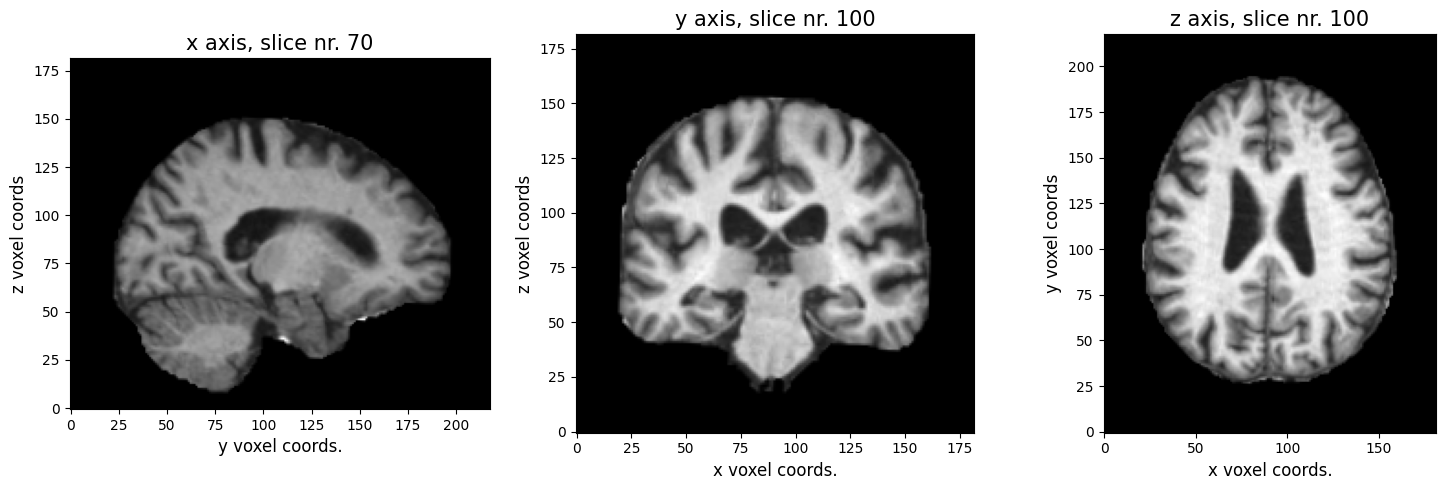

In [18]:
mri_file = data_files[0]
img = nib.load(mri_file)
img_data = img.get_fdata()

print(f'Dimensions of the scan: {img_data.shape}')

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

ax[0].imshow(img_data[69, :, :].T, origin='lower', cmap='gray')
ax[0].set_xlabel('y voxel coords.', fontsize=12)
ax[0].set_ylabel('z voxel coords', fontsize=12)
ax[0].set_title('x axis, slice nr. 70', fontsize=15)

ax[1].imshow(img_data[:, 99, :].T, origin='lower', cmap='gray')
ax[1].set_xlabel('x voxel coords.', fontsize=12)
ax[1].set_ylabel('z voxel coords', fontsize=12)
ax[1].set_title('y axis, slice nr. 100', fontsize=15)

ax[2].imshow(img_data[:, :, 99].T, origin='lower', cmap='gray')
ax[2].set_xlabel('x voxel coords.', fontsize=12)
ax[2].set_ylabel('y voxel coords', fontsize=12)
ax[2].set_title('z axis, slice nr. 100', fontsize=15)

fig.tight_layout()

To run the analysis of MRI volumes, one can use `fsca.pipeline_mri()`.  
This pipeline is a derived class of `fsca.pipeline_3d()`.  
It can handle `.nii.gz` and `.nii` Nifti files as well as NumPy arrays.

⚠️ Note that the default slice axis is `'z'`. So in most cases you will want to specify it explicitly with `slice_axis = 'x'`. If `slice_axis = 'none'`, a 3D hyper-slice will be created instead.

In [19]:
pipe = fsca.pipeline_mri()
pipe.run(scan_file = data_files[0]) # 🧪 Change specify `slice_axis` to other values.

print('\tpipe.fqs',pipe.fqs.shape) # (N_SLICES, N_SCALES, N_QORDERS)
print('\tpipe.scales',pipe.scales.shape) # (N_SLICES, N_SCALES)
print('\tpipe.qorders',pipe.qorders.shape) # (N_QORDERS)
print('\tpipe.ghs', pipe.ghs.shape) # (N_SLICES, N_QORDERS)

print('Chosen Slice axis: ', pipe.slice_axis)

	pipe.fqs (182, 31, 40)
	pipe.scales (182, 31)
	pipe.qorders (40,)
	pipe.ghs (182, 40)
Chosen Slice axis:  z


Let's recall the dimensions of resulting variable:

1. fluctuation function Fq stored as numpy.array with shape:
```pipe.fqs.shape = (N_SLICES, N_SCALES, N_QORDERS)```

2. scale values stored as numpy.array with shape:
```pipe.scales.shape = (N_SLICES, N_SCALES)```

3. q orders stored as numpy.array with shape:
```pipe.qorders.shape (N_QORDERS)```

3. generalized Hurst exponents H stored as numpy.array with shape:
```pipe.ghs.shape = (N_SLICES, N_QORDERS)```

## 🔬 Fluctuation functions

We repeat the code as above for 2D images, but mind the fact that now the arrays have the dimension along the chosen axis and we may choose the slice for 2D analysis:
```
pipe.scales[slice_ix,:]
pipe.fqs[slice_ix, :, :]
pipe.ghs[slice_ix, :]
```


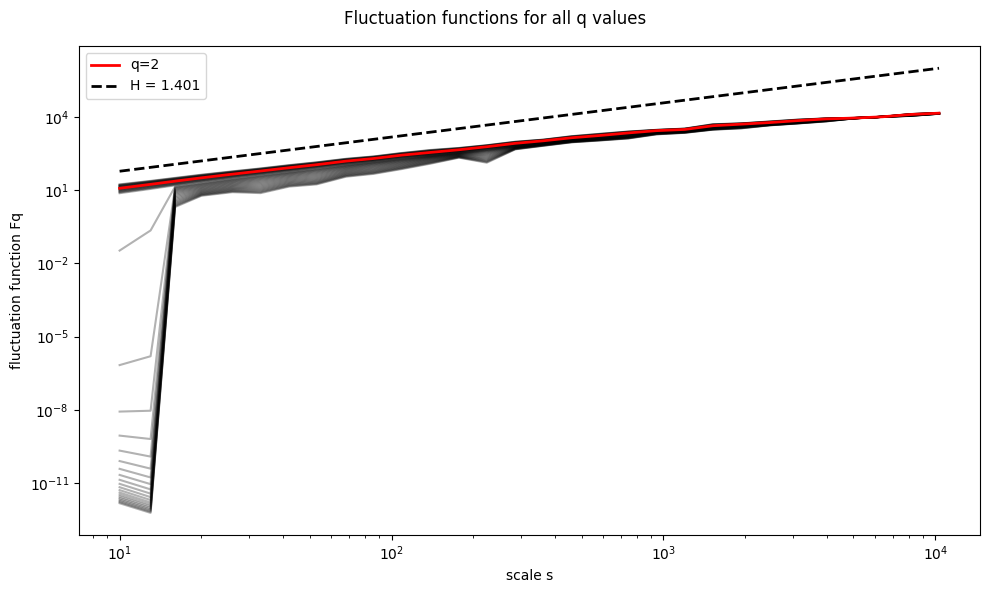

In [ ]:
slice_ix = 100

q_ix_equal_two = np.argwhere(pipe.qorders == 2).item()
min_scale_ix = 0
max_scale_ix = -1

# Plot all fluctuation functions for different q values
fig, ax = plt.subplots(figsize=(10, 6))
s = pipe.scales[slice_ix, min_scale_ix:max_scale_ix]
F2 = pipe.fqs[slice_ix, min_scale_ix:max_scale_ix, q_ix_equal_two]

# Plot all q values
for i in range(pipe.fqs.shape[2]):  # ⚠️
    ax.plot(s, pipe.fqs[slice_ix,min_scale_ix:max_scale_ix, i], '-', alpha=0.3, color='black')  # Adjust q labeling as needed

# Highlight the q=2 case
F2 = pipe.fqs[slice_ix, min_scale_ix:max_scale_ix, q_ix_equal_two]
ax.plot(s, F2, '-', linewidth=2, color='red', label=f'q=2')

# Add the reference line for Hurst exponent
pipe.calc_ghurst()
Hurst_H = pipe.ghs[slice_ix, q_ix_equal_two]
h = s**Hurst_H * s[-1]**(-Hurst_H)
h = h * F2[0] / h[0] * 5 # manually rescale the reference line for clarity
ax.plot(s, h, '--', color='black', linewidth=2, label=f'H = {Hurst_H:.3f}')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('fluctuation function Fq')
ax.set_xlabel('scale s')
ax.legend()
fig.suptitle('Fluctuation functions for all q values')
plt.tight_layout()

⚠️ Now, there are a couple of things that went wrong here.  
First, be aware that when you `pipe.run()` a pipeline, you are running, among others, the methods  
- `pipe.calc_mfdfa()`, which outputs `.fqs`, `.scales`, and `.qorders`,
- `pipe.calc_ghurst()`, which outputs `.ghs`, and  `.ghs_res`.

Now, unless provided a NumPy array in the `scales` argument, the `.calc_mfdfa()` uses a default set of scales to run the computations. The default uses 31 logarithmically spaced scales, starting from 10 up to a maximum inferred from the data.

In [ ]:
# This is our current set of scales
s = pipe.scales[slice_ix,:]
print(s)

#=== 🧪 This shows where the scales are computed.
# from fsca import const
# print(const.DEFAULT_SCALES)
# fsca.pipeline_basic.pipeline_2d._infer_scales(sfc = pipe.sfcs[100],
                                              # scales_params = const.DEFAULT_SCALES)
#=== 🧪

[   10    13    16    20    26    33    42    53    68    86   109   139
   177   224   285   362   460   584   742   943  1198  1521  1933  2455
  3119  3962  5033  6394  8122 10318 13107]


The `.calc_ghurst()` inherits the scales computed above by `.calc_mfdfa()`.

Now, the main question is:  
__what range of scales should you choose to estimate the Hurst exponent__.

So instead of taking the whole range, you can manually set the minimum, maximum or some preset options.

        Parameters
        ----------
        min_scale_ix : int, optional
            The index of the first scale included in the fitting of the generalized Hurst exponent.
        max_scale_ix : int, optional
            The index of the last scale included in the fitting of the generalized Hurst exponent.
        scale_preset : str, optional
            Preset to use when setting min_scale_ix and max_scale_ix automatically.
            Valid options are "all_scales", "small_scales" and "large_scales".

The defaults are extracted below for reference.

In [ ]:
from fsca import const

# Default settings for the scales
print('DEFAULT_SCALES \t\t\t\t', const.DEFAULT_SCALES)
print('DEFAULT_SCALE_PRESET \t\t\t',const.DEFAULT_SCALE_PRESET)
print('DEFAULT_SMALL_SCALES_INTERVAL_SIZE \t',const.DEFAULT_SMALL_SCALES_INTERVAL_SIZE)
print('DEFAULT_LARGE_SCALES_INTERVAL_SIZE \t',const.DEFAULT_LARGE_SCALES_INTERVAL_SIZE)
#
print('Current all scales:\n',s)
print('Current small scales: ',s[:const.DEFAULT_SMALL_SCALES_INTERVAL_SIZE])
print('Current large scales: ', s[-const.DEFAULT_LARGE_SCALES_INTERVAL_SIZE:])

DEFAULT_SCALES 				 (10, None, 30)
DEFAULT_SCALE_PRESET 			 small_scales
DEFAULT_SMALL_SCALES_INTERVAL_SIZE 	 5
DEFAULT_LARGE_SCALES_INTERVAL_SIZE 	 10
Current all scales:
 [   10    13    16    20    26    33    42    53    68    86   109   139
   177   224   285   362   460   584   742   943  1198  1521  1933  2455
  3119  3962  5033  6394  8122 10318 13107]
Current small scales:  [10 13 16 20 26]
Current large scales:  [ 1521  1933  2455  3119  3962  5033  6394  8122 10318 13107]


So let's go back to the previous code and correct the scale issues:
- cut-out some small artifactual scales from the plot,
- choose different scales for calculating the Hurst exponent.

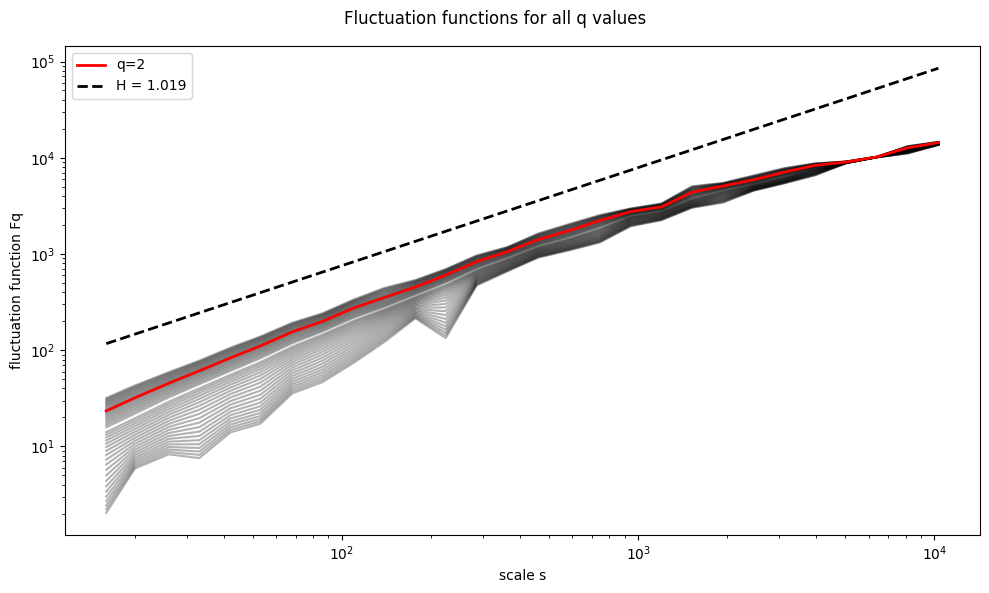

In [ ]:
slice_ix = 100

q_ix_equal_two = np.argwhere(pipe.qorders == 2).item()
#=== 🧪 change this to cut-out the artifactual scales
min_scale_ix = #[your input]
max_scale_ix = #[your input]
#=== 🧪

# Plot all fluctuation functions for different q values
fig, ax = plt.subplots(figsize=(10, 6))
s = pipe.scales[slice_ix, min_scale_ix:max_scale_ix]
F2 = pipe.fqs[slice_ix, min_scale_ix:max_scale_ix, q_ix_equal_two]

# Plot all q values
for i in range(pipe.fqs.shape[2]):  # ⚠️
    ax.plot(s, pipe.fqs[slice_ix,min_scale_ix:max_scale_ix, i], '-', alpha=0.3, color='black')  # Adjust q labeling as needed

# Highlight the q=2 case
F2 = pipe.fqs[slice_ix, min_scale_ix:max_scale_ix, q_ix_equal_two]
ax.plot(s, F2, '-', linewidth=2, color='red', label=f'q=2')

# Add the reference line for Hurst exponent
#=== 🧪 change the following to: 'all_scales', 'small_scales', 'large_scales'
# pipe.calc_ghurst(scale_preset= [your input])
#=== 🧪
Hurst_H = pipe.ghs[slice_ix, q_ix_equal_two]
h = s**Hurst_H * s[-1]**(-Hurst_H)
h = h * F2[0] / h[0] * 5 # manually rescale the reference line for clarity
ax.plot(s, h, '--', color='black', linewidth=2, label=f'H = {Hurst_H:.3f}')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('fluctuation function Fq')
ax.set_xlabel('scale s')
ax.legend()
fig.suptitle('Fluctuation functions for all q values')
plt.tight_layout()

## 📈 Hurst profile

After veryfing that the scales are chosen properly (there might be more than one scaling regime), we can go on looking at the whole brain.

We can provide the scale settings from the start in the `.run()` method:
```
pipe.run( scan_file = data_files[0],
          slice_axis = 'x',
          scale_preset = 'all_scales')
```
The order of processing in `.pipeline_fmri.run()`, where all the arguments are passed down, is:

    .load_data(data,**kwargs)
    .set_proc_mode(**kwargs) # set processing mode (single or batch)
    .slice_data(**kwargs) # output -> self.slices
    .norm_slices(**kwargs) # output -> normalized self.slices
    .map_data_to_sfc(**kwargs) # output -> self.sfcs
    .calc_mfdfa(**kwargs) # output -> self.fqs, .scales, self.qorders
    .calc_ghurst(**kwargs) # output -> self.ghs, self.ghs_res

So later on, if we need to change a given part of the processing, we can still modify it (in this case only the last step):
```
pipe.calc_ghurst(scale_preset = 'large_scales')
```


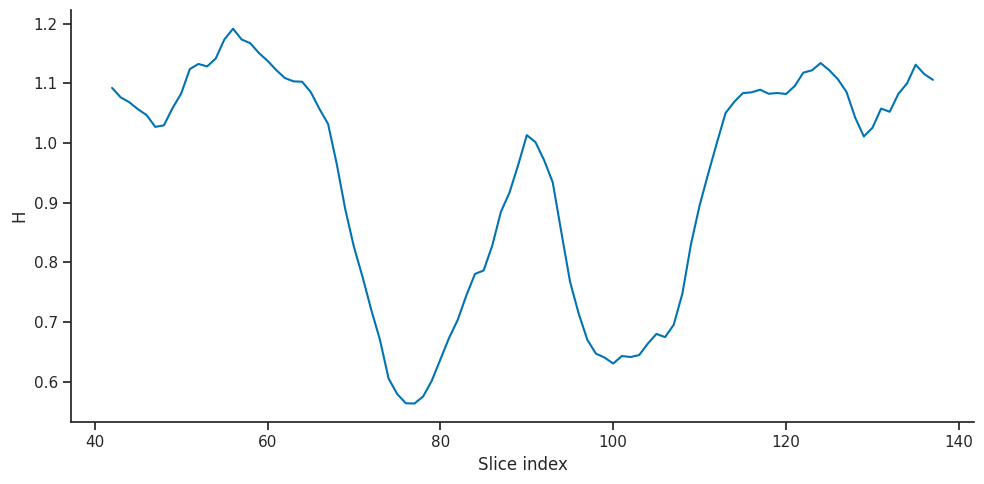

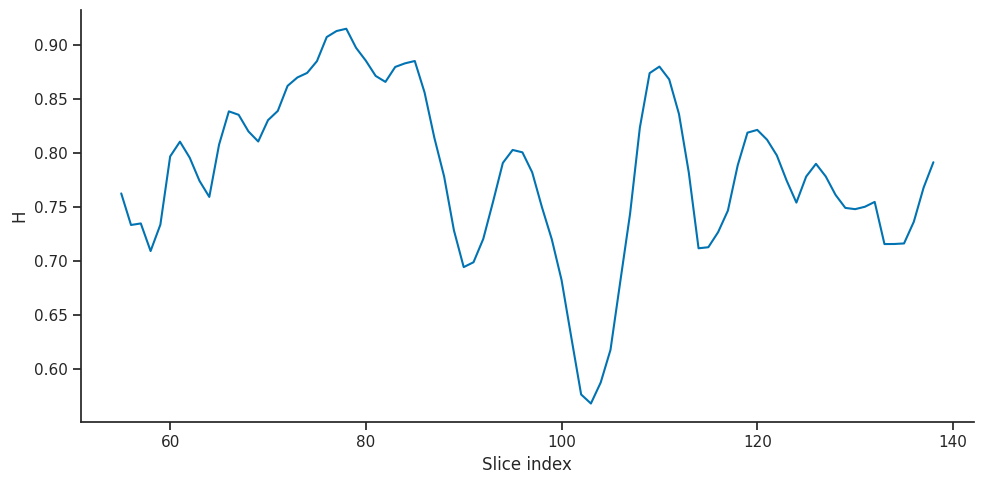

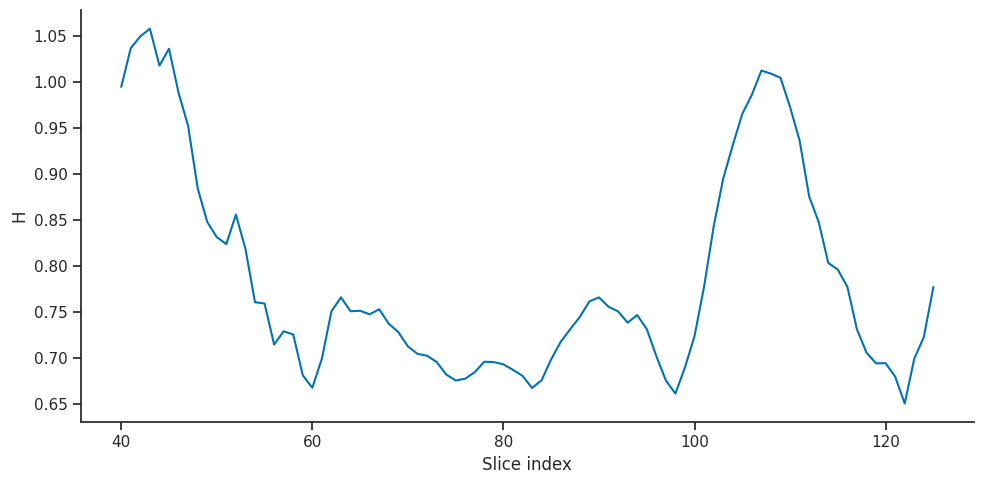

In [ ]:
# 🕓This may take two minutes.


# Set seaborn style and colorblind palette
import seaborn as sns
sns.set_theme(style="ticks", palette="colorblind")

# Build DataFrame with one profile repeated for each axis
axes = ['x', 'y', 'z']
profiles = []
for axis in axes:
    pipe.run(scan_file = data_files[0], slice_axis = axis, scale_preset = 'large_scales')
    hurst_profile = pipe.get_result()
    for i, val in enumerate(hurst_profile):
        profiles.append({
            "slice_ix": i,
            "hurst_value": val,
            "axis": axis
        })

data_df = pd.DataFrame(profiles)


# Create separate lineplots for each axis
for axis in axes:
    g = sns.relplot(
        data=data_df[data_df["axis"] == axis],
        x="slice_ix",
        y="hurst_value",
        kind="line",
        aspect=2
    )
    g.set_axis_labels("Slice index", "H")
    g.set_titles(f"Hurst profile along {axis.upper()} axis")
    plt.show()

As one would expect, the profile along 'x' axis is symmetric. For reference, let us recall how some slices look like, and what anatomical structures they contain.
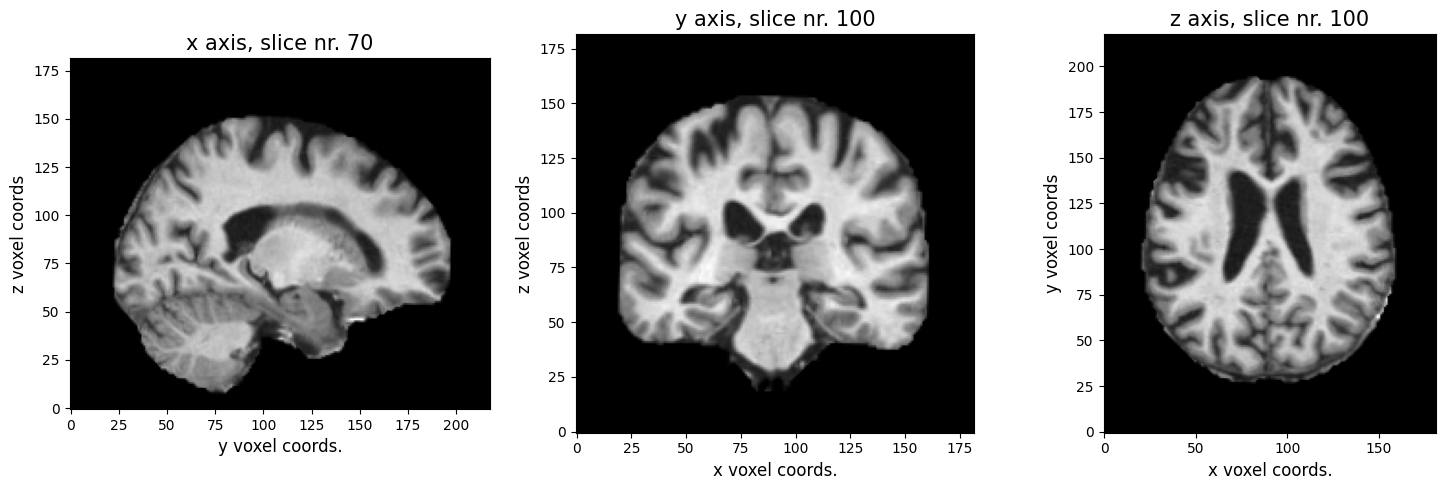

## TO DO:

3. mutlifractal chyba nie działa dla 2d? Zamiast (1 slice,qord-1) jest (qord, qord -1)
4. mutlifractal dla symulowanego 3d daje jakieś dziwne widma alfa....?
5. czy chcemy pokazać jakieś inne parametry `pipeline.basic` póki dane wejściowe są proste? 🥼

# Multi-Fractal DFA

The MFSCA package also allows to compute multifractal features, such as:
- multifractal spectrum,
- spectral width,
- spectral asymmetry.

Currently, they are not included in the `.run()` method, but can be computed separately by calling `.calc_falpha()`.

In [ ]:
pipe.run(scan_file = data_files[0], slice_axis = 'x', scale_preset = 'large_scales')
pipe.calc_falpha()

1. alpha values (x-axis on the spectrum plot) with shape:
```pipe.alphas.shape = (N_SLICES, N_QORDERS-1)```

2. f(alpha) values (y-axis on the spectrum plot) with shape:
```pipe.fs.shape = (N_SLICES, N_QORDERS-1)```

3. Spectral asymmetry with shape:
```pipe.As.shape = (N_SLICES)```

4. Spectra widths with shape:
```pipe.Ds.shape (N_SLICES)```

In [ ]:
print('pipe.alphas',pipe.alphas.shape)
print('pipe.fs',pipe.fs.shape)
print('pipe.As', pipe.As.shape)
print('pipe.Ds', pipe.Ds.shape)

pipe.alphas (182, 39)
pipe.fs (182, 39)
pipe.As (182,)
pipe.Ds (182,)


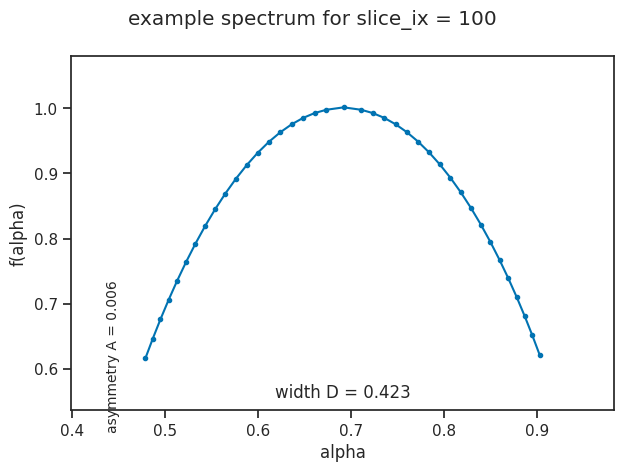

In [ ]:
#=== 🧪 Choose your favourite brain slice
slice_ix = 100 # This one is going to be fairly symmetric
#=== 🧪
width_D = pipe.Ds[slice_ix]
asym_A = pipe.As[slice_ix]
ix_one = np.nanargmin(np.abs(pipe.fs[slice_ix] - 1))

y1 = np.nanmin(pipe.fs[slice_ix,:ix_one])
y2 = np.nanmin(pipe.fs[slice_ix,ix_one:])
ymin, ymax = min(y1,y2), max(y1,y2)

xmin = np.nanmin(pipe.alphas[slice_ix])
xmax = np.nanmax(pipe.alphas[slice_ix])

fig, ax = plt.subplots()

ax.plot(pipe.alphas[slice_ix], pipe.fs[slice_ix],'.-')

y0 = ymin-0.03
ax.annotate("", xytext=(xmin, y0), xy=(xmax, y0), xycoords='data', arrowprops=dict(arrowstyle="<->"))
ax.annotate(f"width D = {width_D:.3f}", xy = ((xmax+xmin)/2,y0),xytext = (0,-4),textcoords = 'offset points', va='top',ha='center', fontsize=12)

x0 = xmin
ax.annotate("", xytext=(xmin-0.02, ymax), xy=(xmin-0.02, ymin), xycoords='data', arrowprops=dict(arrowstyle="<->"))
ax.annotate(f"asymmetry A = {asym_A:.3f}", xy = (x0-0.02,(ymax+ymin)/2),xytext = (-5,0), textcoords = 'offset points', va='center',ha='right', fontsize=10, rotation = 90)


fig.suptitle(f'example spectrum for slice_ix = {slice_ix}')
ax.set_xlabel('alpha')
ax.set_ylabel('f(alpha)')
do = 0.08
ax.set_xlim(xmin-do,xmax+do)
ax.set_ylim(ymin-do,1+do)
fig.tight_layout()

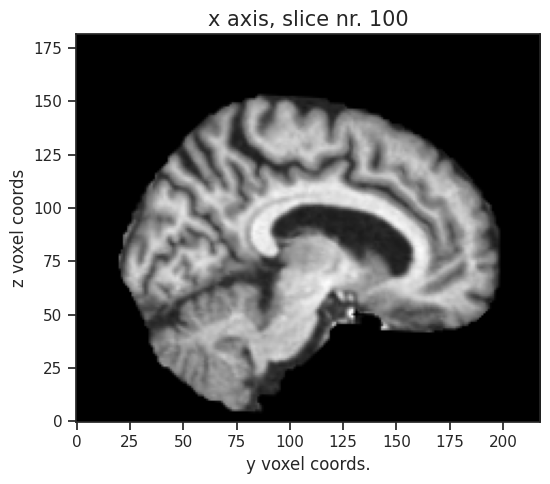

In [ ]:
# Have a look at the brain slice
fig, ax = plt.subplots(ncols=1, figsize=(15, 5))

ax.imshow(img_data[slice_ix-1, :, :].T, origin='lower', cmap='gray')
ax.set_xlabel('y voxel coords.', fontsize=12)
ax.set_ylabel('z voxel coords', fontsize=12)
ax.set_title(f'x axis, slice nr. {slice_ix}', fontsize=15)

fig.tight_layout()

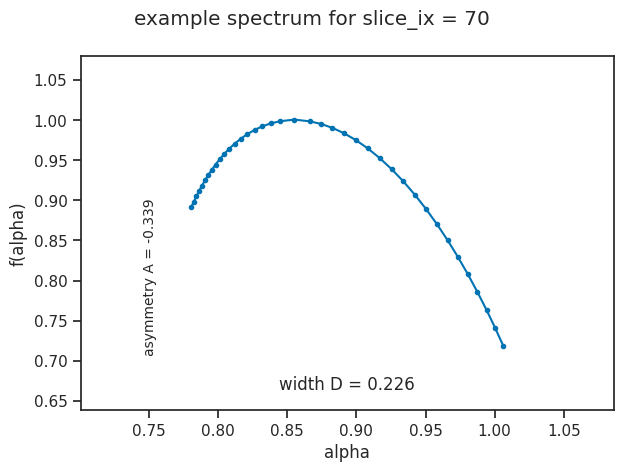

In [ ]:
#=== 🧪 Choose your favourite brain slice
slice_ix = 70 # This one is going to be rather asymmetric
#=== 🧪
width_D = pipe.Ds[slice_ix]
asym_A = pipe.As[slice_ix]
ix_one = np.nanargmin(np.abs(pipe.fs[slice_ix] - 1))

y1 = np.nanmin(pipe.fs[slice_ix,:ix_one])
y2 = np.nanmin(pipe.fs[slice_ix,ix_one:])
ymin, ymax = min(y1,y2), max(y1,y2)

xmin = np.nanmin(pipe.alphas[slice_ix])
xmax = np.nanmax(pipe.alphas[slice_ix])

fig, ax = plt.subplots()

ax.plot(pipe.alphas[slice_ix], pipe.fs[slice_ix],'.-')

y0 = ymin-0.03
ax.annotate("", xytext=(xmin, y0), xy=(xmax, y0), xycoords='data', arrowprops=dict(arrowstyle="<->"))
ax.annotate(f"width D = {width_D:.3f}", xy = ((xmax+xmin)/2,y0),xytext = (0,-4),textcoords = 'offset points', va='top',ha='center', fontsize=12)

x0 = xmin
ax.annotate("", xytext=(xmin-0.02, ymax), xy=(xmin-0.02, ymin), xycoords='data', arrowprops=dict(arrowstyle="<->"))
ax.annotate(f"asymmetry A = {asym_A:.3f}", xy = (x0-0.02,(ymax+ymin)/2),xytext = (-5,0), textcoords = 'offset points', va='center',ha='right', fontsize=10, rotation = 90)


fig.suptitle(f'example spectrum for slice_ix = {slice_ix}')
ax.set_xlabel('alpha')
ax.set_ylabel('f(alpha)')
do = 0.08
ax.set_xlim(xmin-do,xmax+do)
ax.set_ylim(ymin-do,1+do)
fig.tight_layout()

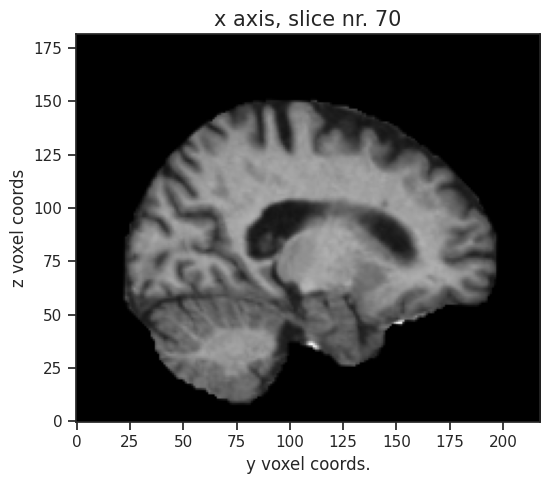

In [ ]:
# Have a look at the brain slice
fig, ax = plt.subplots(ncols=1, figsize=(15, 5))

ax.imshow(img_data[slice_ix-1, :, :].T, origin='lower', cmap='gray')
ax.set_xlabel('y voxel coords.', fontsize=12)
ax.set_ylabel('z voxel coords', fontsize=12)
ax.set_title(f'x axis, slice nr. {slice_ix}', fontsize=15)

fig.tight_layout()

# 🧠🧠🧠 Group analysis MRI

## 📈 Hurst profile

Let us now redo the analysis for all control subjects and compare them.  
We will observe some systematic changes with the age of the subjects.

Let's recall the demographics of these subjects:

In [ ]:
# Keep only rows where 'Cohort' contains "Control"
controls = metadata[metadata["Cohort"].str.contains("Control", case=False)]

controls[['Subject','Cohort','Age','Gender','CDR']]

,Subject,Cohort,Age,Gender,CDR
0,190,Middle Aged Control,43,M,0.0
2,363,Elderly Control,87,M,0.0
3,419,Young Control,21,F,0.0


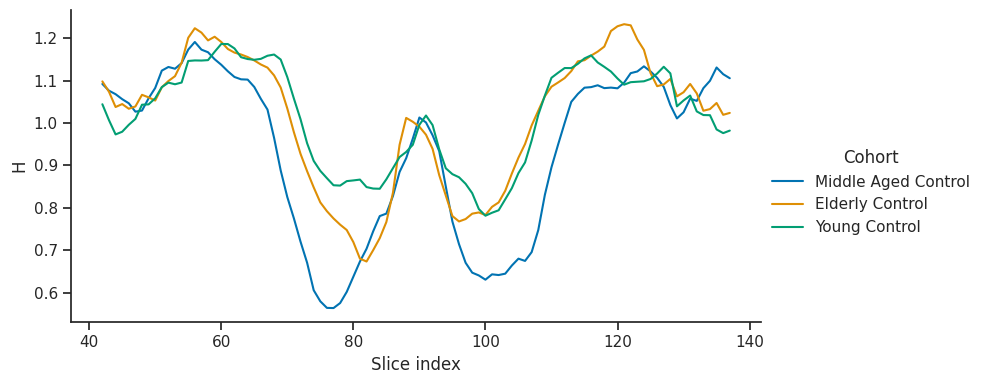

In [ ]:
# 🕓This may take two minutes.

# Keep only rows where 'Cohort' contains "Control"
controls = metadata[metadata["Cohort"].str.contains("Control", case=False)]

# Build DataFrame for selected cohorts (x-axis only)
profiles = []
for f, cohort in zip(controls["file_name"], controls["Cohort"]):
    pipe.run(scan_file=f, slice_axis='x', scale_preset='large_scales')
    hurst_profile = pipe.get_result()
    for i, val in enumerate(hurst_profile):
        profiles.append({
            "slice_ix": i,
            "hurst_value": val,
            "Cohort": cohort
        })

data_df = pd.DataFrame(profiles)

g = sns.relplot(
    data=data_df,
    x="slice_ix",
    y="hurst_value",
    hue="Cohort",      # legend by cohort
    kind="line",
    aspect=2,
    height=4
)

g.set_axis_labels("Slice index", "H")
g.set_titles("Hurst profiles along X axis (Control cohorts only)")
plt.show()

Now, let's look only at the elderly people with and without dementia.

In [ ]:
elderly = metadata[metadata["Age"]>60]
elderly[['Subject','Cohort','Age','Gender','CDR']]

,Subject,Cohort,Age,Gender,CDR
1,268,MCI,78,M,1.0
2,363,Elderly Control,87,M,0.0
4,451,EMCI,73,M,0.5


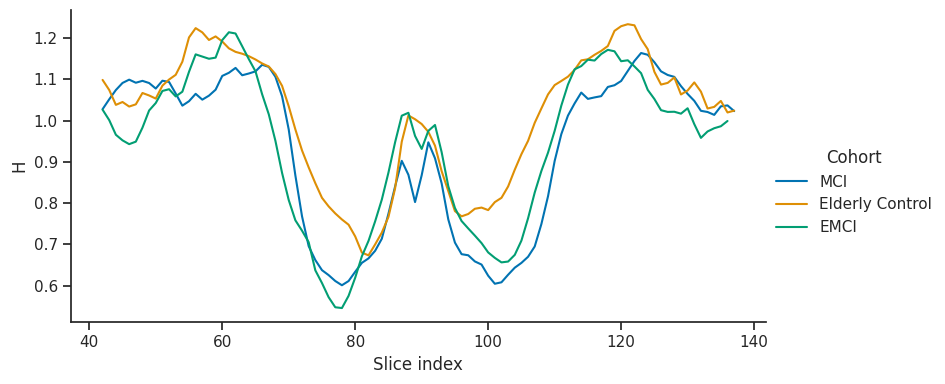

In [ ]:
# 🕓This may take two minutes.

# Build DataFrame for selected cohorts (x-axis only)
profiles = []
for f, cohort in zip(elderly["file_name"], elderly["Cohort"]):
    pipe.run(scan_file=f, slice_axis='x', scale_preset='large_scales')
    hurst_profile = pipe.get_result()
    for i, val in enumerate(hurst_profile):
        profiles.append({
            "slice_ix": i,
            "hurst_value": val,
            "Cohort": cohort
        })

data_df = pd.DataFrame(profiles)

g = sns.relplot(
    data=data_df,
    x="slice_ix",
    y="hurst_value",
    hue="Cohort",      # legend by cohort
    kind="line",
    aspect=2,
    height=4
)

g.set_axis_labels("Slice index", "H")
g.set_titles("Hurst profiles along X axis (Control cohorts only)")
plt.show()